# GQA

# Setup

In [1]:
import sys
import warnings

from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.transforms import ScaledTranslation, Affine2D
import seaborn as sns
import torch

In [2]:
# Ignore all warnings
warnings.filterwarnings("ignore")

# Torch display options
torch.set_printoptions(linewidth=120)

# Hyperparams

In [31]:
d_model = 16
n_query_heads = 8
d_head = d_model // n_query_heads
n_kv_heads = 2
n = 1
dpi = plt.rcParams['figure.dpi']

# Embeddings

Simulate embeddings.

In [32]:
ROW_MASK = 0x00000000000000ff
ROW_SHIFT = 0

def row(value):
    return (value & ROW_MASK) >> ROW_SHIFT

def set_row(value, v):
    return (value & ~ROW_MASK) | (v << ROW_SHIFT)


COL_MASK = 0x000000000000ff00
COL_SHIFT = 8

def col(value):
    return (value & COL_MASK) >> COL_SHIFT

def set_col(value, v):
    return (value & ~COL_MASK) | (v << COL_SHIFT) 

POSITION_MASK = 0x0000000000ff0000
POSITION_SHIFT = 16

def position(value):
    return (value & POSITION_MASK) >> POSITION_SHIFT

def set_position(value, v):
    return (value & ~POSITION_MASK) | (v << POSITION_SHIFT)


DIMENSION_MASK = 0x00000000ff000000
DIMENSION_SHIFT = 24

def dimension(value):
    return (value & DIMENSION_MASK) >> DIMENSION_SHIFT

def set_dimension(value, v):
    return (value & ~DIMENSION_MASK) | (v << DIMENSION_SHIFT) 


HEAD_MASK = 0x000000ff00000000
HEAD_SHIFT = 32

def head(value):
    return (value & HEAD_MASK) >> HEAD_SHIFT

def set_head(value, v):
    return (value & ~HEAD_MASK) | (v << HEAD_SHIFT)


CELL_SIZE = 48
CELL_PADDING = 16
CELL_OFFSET = CELL_SIZE + CELL_PADDING


def plot_cell(value, ax, transform):

    r = row(value)
    c = col(value)
    
    p = sns.color_palette()
    x = CELL_OFFSET*c
    y = CELL_OFFSET*(n - 1 - r)
    h = head(value)
    color = "white" if h == 0 else p[h-1]

    # Translate x, y
    transform = transform + Affine2D().translate(x, y)

    # Convert data to screen
    transform = transform + ax.transData

    # Cell at 0, 0
    ax.add_artist(Rectangle((0, 0), CELL_SIZE, CELL_SIZE, facecolor=color, edgecolor="black", transform=transform))

    # dimension
    text = f"{dimension(value)}"
    center_x = CELL_SIZE / 2
    center_y = CELL_SIZE / 2
    ax.text(center_x, center_y, text, ha="center", va="center", fontsize=10, color="black", transform=transform)


def plot_embeddings(x):

    # Plot size
    plot_size = d_model * CELL_OFFSET + CELL_PADDING
    
    # Create plot_size x plot_size figure
    fig, ax = plt.subplots(figsize=(plot_size/dpi,plot_size/dpi))
    ax.set_aspect(1)
    ax.set_xlim([0, plot_size])
    ax.set_ylim([0, n*CELL_OFFSET + CELL_PADDING])
    ax.set_axis_off()
    
    transform = Affine2D()

    # Plot margin
    transform = transform + Affine2D().translate(CELL_PADDING, CELL_PADDING)

    # Plot each value in x
    for v in torch.flatten(x):
        plot_cell(v, ax=ax, transform=transform)

In [40]:
ROW_MASK = 0x00000000000000ff
ROW_SHIFT = 0

def row(value):
    return (value & ROW_MASK) >> ROW_SHIFT

def set_row(value, v):
    return (value & ~ROW_MASK) | (v << ROW_SHIFT)


COL_MASK = 0x000000000000ff00
COL_SHIFT = 8

def col(value):
    return (value & COL_MASK) >> COL_SHIFT

def set_col(value, v):
    return (value & ~COL_MASK) | (v << COL_SHIFT) 

POSITION_MASK = 0x0000000000ff0000
POSITION_SHIFT = 16

def position(value):
    return (value & POSITION_MASK) >> POSITION_SHIFT

def set_position(value, v):
    return (value & ~POSITION_MASK) | (v << POSITION_SHIFT)


DIMENSION_MASK = 0x00000000ff000000
DIMENSION_SHIFT = 24

def dimension(value):
    return (value & DIMENSION_MASK) >> DIMENSION_SHIFT

def set_dimension(value, v):
    return (value & ~DIMENSION_MASK) | (v << DIMENSION_SHIFT) 


HEAD_MASK = 0x000000ff00000000
HEAD_SHIFT = 32

def head(value):
    return (value & HEAD_MASK) >> HEAD_SHIFT

def set_head(value, v):
    return (value & ~HEAD_MASK) | (v << HEAD_SHIFT)


CELL_SIZE = 48
CELL_PADDING = 16
CELL_OFFSET = CELL_SIZE + CELL_PADDING


def plot_cell(value, ax, transform):

    p = sns.color_palette()
    h = head(value)
    color = "white" if h == 0 else p[h-1]

    # Convert data to screen
    transform = transform + ax.transData

    # Cell at 0, 0
    ax.add_artist(Rectangle((0, 0), CELL_SIZE, CELL_SIZE, facecolor=color, edgecolor="black", transform=transform))

    # # dimension
    text = f"{dimension(value)}"
    center_x = CELL_SIZE / 2
    center_y = CELL_SIZE / 2
    ax.text(center_x, center_y, text, ha="center", va="center", fontsize=10, color="black", transform=transform)


def plot_embeddings(x):

    # Plot size
    plot_size = d_model * CELL_OFFSET + CELL_PADDING
    
    # Create plot_size x plot_size figure
    fig, ax = plt.subplots(figsize=(plot_size/dpi,plot_size/dpi))
    ax.set_aspect(1)
    ax.set_xlim([0, plot_size])
    ax.set_ylim([0, n*CELL_OFFSET + CELL_PADDING])
    ax.set_axis_off()

    # Start w/ identity
    transform = Affine2D()

    # Plot margin
    transform = transform + Affine2D().translate(CELL_PADDING, CELL_PADDING)

    # Make sure x always has 3 dimensions (h, n, d)
    if len(x.shape) == 2:
        x = x.unsqueeze(0)
    assert len(x.shape) == 3

    # Heads
    for h in range(x.shape[0]):
        head_transform = transform + Affine2D().translate(h*CELL_OFFSET, 0)
        
        # Rows
        for r in range(x.shape[1]):
            row_transform = head_transform + Affine2D().translate(0, r*CELL_OFFSET)
            
            # Cols
            for c in range(x.shape[2]):
                col_transform = row_transform + Affine2D().translate(c*CELL_OFFSET, 0)
                print(f"{h}, {r}, {c}")
                plot_cell(x[h, r, c], ax=ax, transform=col_transform)

In [41]:
def embeddings(n, d):
    # Simulate n x d embeddings
    values = []
    for i in range(n):
        for j in range(d):
            value = 0
            value = set_col(value, j)
            value = set_row(value, i)
            value = set_dimension(value, j)
            value = set_position(value, i)
            values.append(value)
    
    x = torch.tensor(values).reshape(n, -1)

    return x


def split_heads(x, n_heads):

    # Split heads
    x = x.view(-1, n_heads, d_head).transpose(-3, -2)
    
    # Assign color by head
    for h in range(n_heads):
        n = x[h].shape[0]
        d = x[h].shape[1]
        
        for i in range(n):
            for j in range(d):
                x[h, i, j] = set_head(x[h, i, j].item(), h+1)
    
    return x


def combine_heads(x, n_heads):
    # Combine heads
    x = x.transpose(-3, -2).contiguous().view(-1, int(n_heads * d_head))

    # Clear heads
    n = x.shape[0]
    d = x.shape[1]
    
    for i in range(n):
        for j in range(d):
            x[i, j] = set_head(x[i, j].item(), 0)

    return x


# Queries, Keys, Values

In [42]:
# Generate embeddings
q = embeddings(n, n_query_heads*d_head)
k = embeddings(n, n_kv_heads*d_head)

q.shape, k.shape

(torch.Size([1, 16]), torch.Size([1, 4]))

0, 0, 0
0, 0, 1
0, 0, 2
0, 0, 3
0, 0, 4
0, 0, 5
0, 0, 6
0, 0, 7
0, 0, 8
0, 0, 9
0, 0, 10
0, 0, 11
0, 0, 12
0, 0, 13
0, 0, 14
0, 0, 15


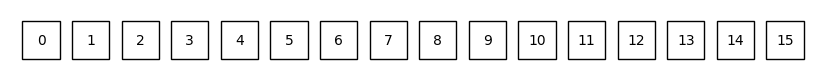

In [43]:
plot_embeddings(q)

0, 0, 0
0, 0, 1
0, 0, 2
0, 0, 3


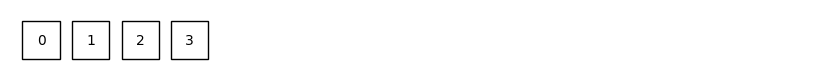

In [44]:
plot_embeddings(k)

In [45]:
# Split attention heads
q = split_heads(q, n_query_heads)
k = split_heads(k, n_kv_heads)

q.shape, k.shape

(torch.Size([8, 1, 2]), torch.Size([2, 1, 2]))

0, 0, 0
0, 0, 1
1, 0, 0
1, 0, 1
2, 0, 0
2, 0, 1
3, 0, 0
3, 0, 1
4, 0, 0
4, 0, 1
5, 0, 0
5, 0, 1
6, 0, 0
6, 0, 1
7, 0, 0
7, 0, 1


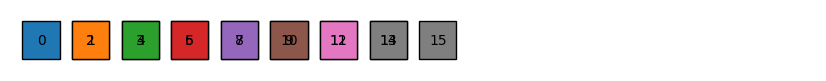

In [46]:
plot_embeddings(q)

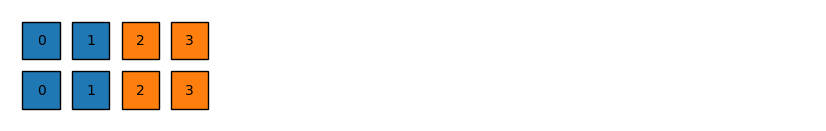

In [11]:
plot_embeddings(k)

In [12]:
# Expand key/value heads
nreps = n_query_heads // n_kv_heads
k = k.repeat_interleave(nreps, dim=0)

# Update head, row / col
for h in range(k.shape[-3]):
    for i in range(k.shape[-2]):
        for j in range(k.shape[-1]):
            value = k[h, i, j].item()
            value = set_row(value, i)
            value = set_col(value, h*k.shape[-1] + j)
            value = set_head(value, h + 1)            
            k[h, i, j] = value

k.shape

torch.Size([8, 2, 2])

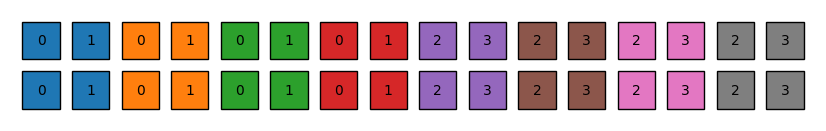

In [13]:
plot_embeddings(k)

In [14]:
# Combine
q = combine_heads(q, n_query_heads)
k = combine_heads(k, n_kv_heads)

q.shape, k.shape

(torch.Size([2, 16]), torch.Size([8, 4]))

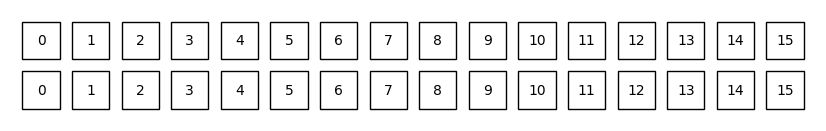

In [15]:
plot_embeddings(q)

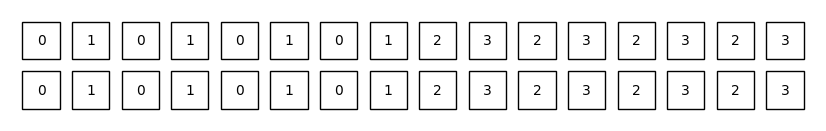

In [16]:
plot_embeddings(k)